We start with **Data Preprocessing**

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Hint: you can replace it with your own MNIST data set

In [2]:
data = pd.read_csv("./data/train.csv")

In the MNIST training dataset, each row represents one image, and each column represents one pixel in that image.

Each image is 28 × 28 pixels, so there are 784 pixels in total, for example:

    label, pixel1, pixel2, ..., pixel784

The pixel values are grayscale, ranging from 0 (white) to 255 (black).


This is a simple function that uses `plt` to display images represented by specific rows:

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def display_image(data, row):
    pixels = data.iloc[row, 1:] 
    label = data.iloc[row, 0]   
    image = np.array(pixels).reshape(28, 28)
    plt.figure()
    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {label}")
    plt.show()

Let's try to display the 0th picture

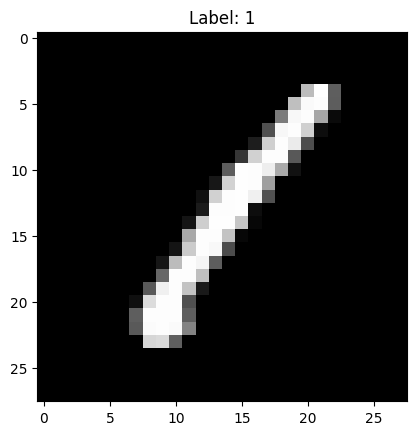

In [9]:
display_image(data, 0)

Then, let's split the data into two parts, 20% for testing set, 80% for training set.

After that, we need to do normalization: `X = X / 255.0`, because shrinking the value to `[0,1]` makes the training more stable and the gradient smoother.

Finally, we perform standardization: `StandardScaler()`, because after standardization, different dimensions are in a "fair" state, making it easier to converge and improve performance.

In [10]:
# Split the data into features and target variable
X = data.drop("label", axis=1)
y = data["label"]

# Normalize the features
X = X / 255.0

# Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

However, we have a total of 28 * 28=784 dimensions, and such a high number of dimensions can easily lead to overfitting if used directly for training. Therefore, we use PCA for dimensionality reduction

In [11]:
from sklearn.decomposition import PCA

To find the optimal PCA parameters, we plot the Number of PCs vs Explained Variance：

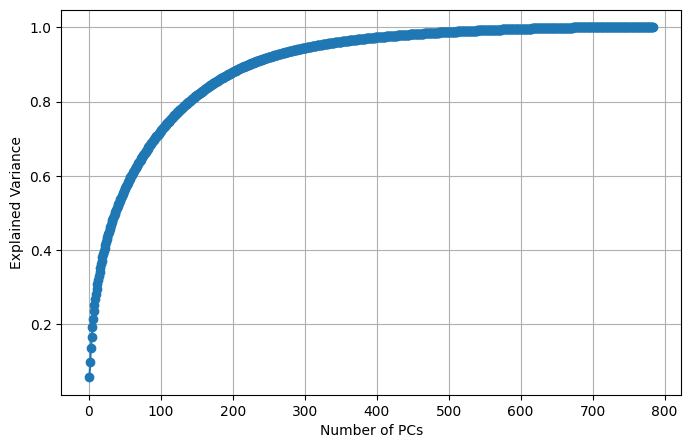

In [11]:
# Fit PCA on the training data
pca = PCA()
pca.fit(X_train)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

# Display the explained variance ratio
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.xlabel('Number of PCs')
plt.ylabel('Explained Variance')
plt.grid(True)
plt.show()


We can select the *knee* point on this graph as our PCA parameter, which appears to be around 180.

As we can see, when the number of Pcs exceeds 200, the curve flattens out—indicating that adding more components provides little additional information. On the other hand, when the number drops below 100, the curve declines sharply, meaning we lose a significant amount of information. Therefore, choosing 180 (knee point) as our PCA parameter is a safe and balanced option.

In [12]:
pca = PCA(n_components=180)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

This function displays a reconstructed image from a specific row in the dataset after applying PCA and then reversing it back to the original image space, so that we can see how many features are retained after our PCA

In [13]:
def display_pca_image(data, row, scaler, pca):
    pixels = data.iloc[row, 1:].values / 255.0  # Normalize the pixel values
    label = data.iloc[row, 0]

    pixels_scaled = scaler.transform([pixels])

    pixels_pca = pca.transform(pixels_scaled)
    pixels_reconstructed = pca.inverse_transform(pixels_pca)

    pixels_unscaled = scaler.inverse_transform(pixels_reconstructed)

    image = np.array(pixels_unscaled).reshape(28, 28)

    plt.figure()
    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {label}")
    plt.show()


We can observe that after PCA with n=180, most of the features are preserved:

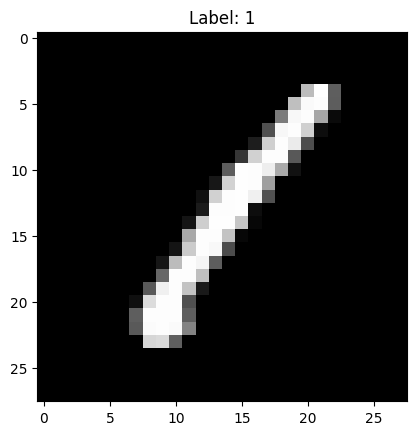

c:\Users\24701\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


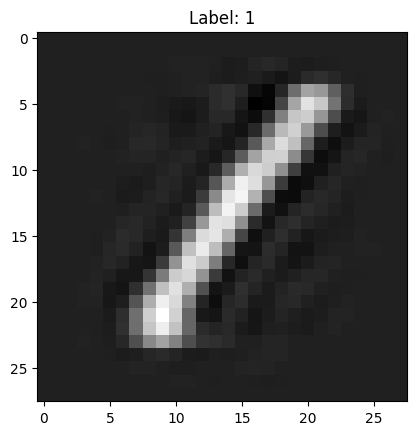

In [14]:
display_image(data, 0)
display_pca_image(data, row=0, scaler=scaler, pca=pca)

Next, we use `[10, 100, 500, 1000]` as parameters for the **Random Forest Classifier** to fit and determine which parameter to choose

In [14]:
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics

Hint: this may take about 15 minutes to complete

Number of trees: 10, Accuracy: 0.8872619047619048
Number of trees: 100, Accuracy: 0.9383333333333334
Number of trees: 500, Accuracy: 0.9430952380952381
Number of trees: 1000, Accuracy: 0.9439285714285715


Text(0.5, 1.0, 'Random Forest Classifier Accuracy vs Number of Trees')

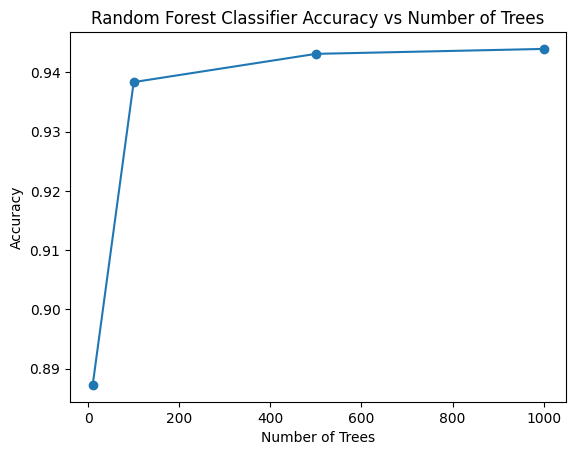

In [18]:
# Initialize the Random Forest Classifier with hyperparameters
n_trees = [10, 100, 500, 1000]
results = []

# Train the model with different numbers of trees
# progress = 1
for n in n_trees:
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    acc = metrics.accuracy_score(y_test, y_pred)
    results.append((n, acc))
    print(f"Number of trees: {n}, Accuracy: {acc}")

# plot the results
plt.figure()
plt.plot([n for n, acc in results], [acc for n, acc in results], marker='o')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy') 
plt.title('Random Forest Classifier Accuracy vs Number of Trees')

We found that there was no significant improvement after n exceeded 100

In [19]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Next, we use `[0.01, 0.1, 1.0, 10.0]` as parameters for the **Logistic Regression Classifier** to fit and determine which parameter to choose

C: 0.01, Accuracy: 0.9172619047619047
C: 0.1, Accuracy: 0.9173809523809524
C: 1.0, Accuracy: 0.9164285714285715
C: 10.0, Accuracy: 0.916547619047619


Text(0.5, 1.0, 'Logistic Regression Accuracy vs C')

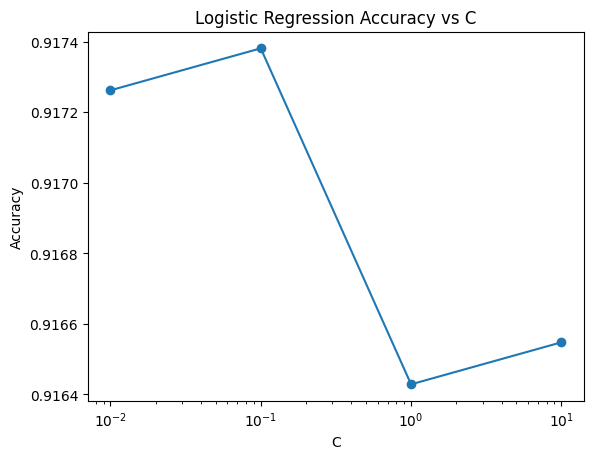

In [21]:
from sklearn.linear_model import LogisticRegression

Cs = [0.01, 0.1, 1.0, 10.0]
results = []

for c in Cs:
    lr = LogisticRegression(C=c, max_iter=1000, random_state=42)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    acc = metrics.accuracy_score(y_test, y_pred)
    results.append((c, acc))
    print(f"C: {c}, Accuracy: {acc}")

# Plot the results
plt.figure()
plt.plot(Cs, [r[1] for r in results], marker='o')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('Logistic Regression Accuracy vs C')


Therefore, we choose C = 0.1

In [22]:
logreg = LogisticRegression(C=0.1, max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

LogisticRegression(C=0.1, max_iter=1000, random_state=42)

We can save the parameters we trained on locally, otherwise it would take a very long time to retrain each time!

In [4]:
import pickle

rf_path = "./save/rf_model.pkl"
logreg_path = "./save/logreg_model.pkl"

Saving parameters:

In [24]:
with open(rf_path, "wb") as f:
    pickle.dump(rf, f)

with open(logreg_path, "wb") as f:
    pickle.dump(logreg, f)

Reading parameters:

In [5]:
with open(rf_path, "rb") as f:
    rf = pickle.load(f)

with open(logreg_path, "rb") as f:
    logreg = pickle.load(f)

Next, let's test our models:

In [6]:
def preprocess_sample(data, idx, scaler, pca):
    import numpy as np

    # take the pixel values and label
    x = data.drop("label", axis=1).iloc[idx].values.astype(np.float32)
    x = x / 255.0
    x = scaler.transform([x])
    x = pca.transform(x)
    return x[0]

Random Forest Prediction: [1]


c:\Users\24701\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


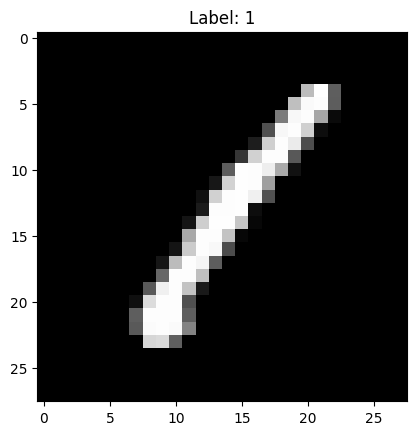

c:\Users\24701\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Logistic Regression Prediction: [1]


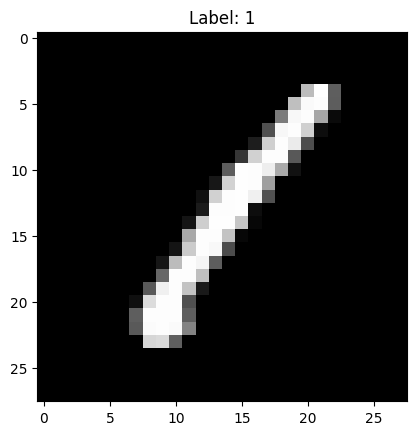

In [27]:
idx = 0

pre = rf.predict([preprocess_sample(data, idx, scaler, pca)])
print(f"Random Forest Prediction: {pre}")
display_image(data, idx)

pre = logreg.predict([preprocess_sample(data, idx, scaler, pca)])
print(f"Logistic Regression Prediction: {pre}")
display_image(data, idx)

In addition, we can use `tkinter` to create an app to see the performance of our models in real-world scenarios:

In [7]:
import tkinter as tk
from PIL import Image, ImageDraw, ImageOps

class NavieDigitRecognizer:
    def __init__(self, master, model, scaler, pca):
        self.master = master
        master.title("Digit Recognizer")

        self.model = model
        self.scaler = scaler
        self.pca = pca

        self.canvas = tk.Canvas(master, width=280, height=280, bg='white')
        self.canvas.pack()

        self.button_predict = tk.Button(master, text="Recognize", command=self.predict_digit)
        self.button_predict.pack()

        self.button_clear = tk.Button(master, text="Clear", command=self.clear_canvas)
        self.button_clear.pack()

        self.label_result = tk.Label(master, text="", font=("Helvetica", 24))
        self.label_result.pack()

        # I use 280x280 to draw because it is easier to draw on a larger canvas
        # and then resize it to 28x28 for prediction
        self.image = Image.new("L", (280, 280), color=255) 
        self.draw = ImageDraw.Draw(self.image)

        self.canvas.bind("<B1-Motion>", self.paint)

    def paint(self, event):
        # I use r = 8 to draw, but it is not exactly the same as the training data, so this is a bit imprecise
        x, y = event.x, event.y
        r = 8
        self.canvas.create_oval(x - r, y - r, x + r, y + r, fill='black')
        self.draw.ellipse([x - r, y - r, x + r, y + r], fill=0)

    def clear_canvas(self):
        self.canvas.delete("all")
        self.draw.rectangle([0, 0, 280, 280], fill=255)
        self.label_result.config(text="")

    def preprocess_input(self):
        # Image to 28x28 array
        image_resized = self.image.resize((28, 28), resample=Image.Resampling.LANCZOS)
        image_inverted = ImageOps.invert(image_resized)
        image_array = np.array(image_inverted).astype("float32") / 255.0
        image_flat = image_array.flatten().reshape(1, -1)

        # Apply StandardScaler and PCA (as during training)
        image_scaled = self.scaler.transform(image_flat)
        image_pca = self.pca.transform(image_scaled)

        return image_pca  # shape = (1, n_components)

    def predict_digit(self):
        x_input = self.preprocess_input()
        prediction = self.model.predict(x_input)[0]
        self.label_result.config(text=f"Predictive result: {prediction}")

        plt.figure()
        plt.imshow(self.image, cmap='gray')
        plt.title(f"Predicted: {prediction}")
        plt.axis('off')


c:\Users\24701\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\24701\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\24701\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


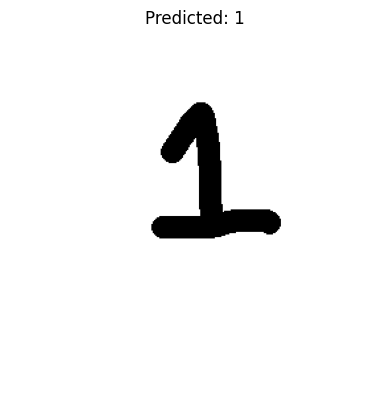

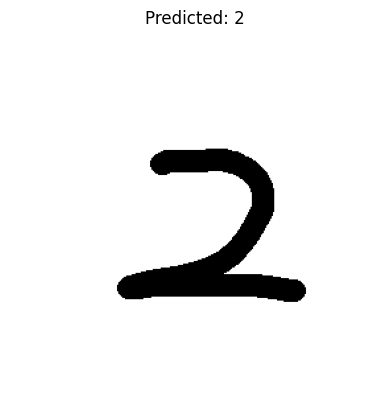

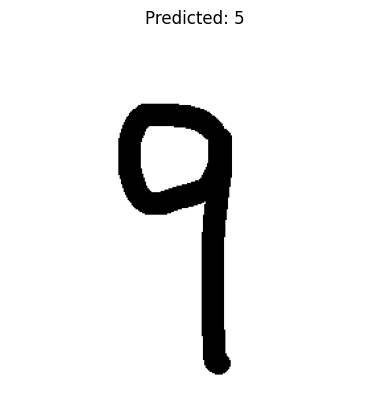

In [29]:
root = tk.Tk()
app = NavieDigitRecognizer(root, model=rf, scaler=scaler, pca=pca)
root.mainloop()

In [30]:
root = tk.Tk()
app = NavieDigitRecognizer(root, model=logreg, scaler=scaler, pca=pca)
root.mainloop()

Oops! Our rf & logreg models seem to have made a prediction error on the digit 9!

Even though all the models achieve over 90% accuracy on the test set, they don’t perform well in real-world scenarios. To explore this further, I manually created a custom test set (`./save/handwritten-digits.csv`) using `LoopDigitCollector.py`. Let’s take a look at how our models perform on my own handwritten dataset.

In [8]:
def evaluate_on_custom_csv(csv_path, models, scaler, pca):
    import pandas as pd
    from sklearn.metrics import accuracy_score

    # read the custom CSV file
    data = pd.read_csv(csv_path)
    X = data.drop("label", axis=1).astype("float32") / 255.0  # normalize the pixel values
    y = data["label"].astype("int")

    X_scaled = scaler.transform(X)
    X_pca = pca.transform(X_scaled)

    for name, model in models.items():
        y_pred = model.predict(X_pca)
        acc = accuracy_score(y, y_pred)
        print(f"{name} Accuracy on handwritten test set: {acc}")


In [15]:
custom_csv_path = "./save/handwritten_digits.csv"

models = {"Random Forest": rf, "Logistic Regression": logreg}

evaluate_on_custom_csv(custom_csv_path, models, scaler, pca)


Random Forest Accuracy on handwritten test set: 0.52
Logistic Regression Accuracy on handwritten test set: 0.32


Poor low 👎👎👎👎👎

This highlights a fundamental limitation of traditional machine learning models: they treat images as long flat arrays, focusing on individual pixel values rather than the spatial structure of the image as a whole. In real-world scenarios, however, handwriting varies greatly from person to person — in size, position, and style.

Hence, our models tend to “overfit” to the specific writing patterns found in the original dataset. This is a special kind of "overfitting": not in the traditional sense (where the model performs poorly on the test set), but in the sense that the model becomes overly reliant on the writing style of the original dataset’s **authors**. When tested on digits written by different individuals, the model’s performance breaks down.

To address this, we need more suitable models for image data — such as Convolutional Neural Networks (CNNs), which are capable of capturing spatial hierarchies and generalizing better across different handwriting styles.

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

We use `DataLoader` class here, `DataLoader` is used to efficiently load and batch the dataset, enabling mini-batch training and automatic shuffling.

It is useful for training CNNs

The `DataLoader` class is something like this:

    DataLoader(
        dataset,        # Our dataset (Dataset)
        batch_size,     # The size of batch (int)
        shuffle,        # Do we need to shuffle the data before each epoch? (bool)
        num_workers,    # Number of threads used (int)
        drop_last       # If the dataset cannot be divided, should the last batch be discarded? (bool)
    )

So, we need a `Dataset` object as input

In [17]:
class MNISTFromCSV(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.reshape(-1, 1, 28, 28), dtype=torch.float32)  # CNN needs [B, 1, 28, 28]
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [18]:
X = data.drop("label", axis=1).values / 255.0
y = data["label"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

train_dataset = MNISTFromCSV(X_train, y_train)
test_dataset = MNISTFromCSV(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Notice that the dataset retains the size of images (28 * 28) instead of flattening them into a single array

In [19]:
print (f"X shape: {X_train.shape}, dataset shape: {train_dataset.X.shape}")

X shape: (33600, 784), dataset shape: torch.Size([33600, 1, 28, 28])


Next, we will complete our simple CNN module.

Some key functions:

    nn.Conv2d(
        input_channels,     # The number of channels in the input image (1 for grayscale images)
        output_channels,    # Number of output feature maps
        kernel_size,        # The size of the convolution kernel, like 3 or (3,3)
        stride,             # The distance the convolution kernel moves each time, defaults to 1
        padding             # Padding=1 can maintain size
    )

*nn.Conv2d* applies a set of kernels to extract spatial features from images

    BatchNorm2d(
        num_features        # The number of features
    )
    
*nn.BatchNorm2d* normalizes each channel across the batch

    nn.MaxPool2d(
        kernel_size,            # Size of pooling window
        stride,                 # The distance for each sliding of the window
        padding=0
    )

*nn.MaxPool2d* performs downsampling by selecting the maximum value in each small window

    nn.Dropout(
        p                       # The probability of each neuron being set to 0
    )

*nn.Dropout* avoids overfitting




Doubling the number of channels after each convolutional block is a widely used design pattern in CNNs — it helps maintain or increase model capacity as spatial dimensions decrease, enabling the network to learn more complex and abstract features effectively.

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1) 
        self.bn2 = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(2, 2)               
        self.dropout1 = nn.Dropout(0.25)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.pool2 = nn.MaxPool2d(2, 2)              
        self.dropout2 = nn.Dropout(0.25)

        self.fc1 = nn.Linear(256 * 7 * 7, 256)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout1(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)

        x = x.view(-1, 256 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = F.log_softmax(self.fc2(x), dim=1)
        return x

Now, we'll train our model, I use **Negative Log-Likelihood Loss** as the loss function (`torch.nn.functional.nll_loss`):

$$\text{nll} (\log p, y) = \frac{1}{N} \sum_{i = 1}^N - \log p^{(i)}_{y_i}$$

Hint: we should clear the gradient each time, because the default setting of PyTorch is that gradients are accumulated (`zero_grad()`)

In [30]:
cnn = CNN()
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)

for epoch in range(5):
        running_loss = 0.0
        cnn.train()
        for x, y in train_loader:
            # Clear the gradient information from the previous round
            optimizer.zero_grad()

            output = cnn(x)
            loss = torch.nn.functional.nll_loss(output, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1}, Avg Loss: {avg_loss:.4f}")

Epoch 1, Avg Loss: 0.4053
Epoch 2, Avg Loss: 0.1439
Epoch 3, Avg Loss: 0.1127
Epoch 4, Avg Loss: 0.0956
Epoch 5, Avg Loss: 0.0858


In [31]:
CNN_path = "./save/CNN_model.pth"

In [32]:
with open(CNN_path, "wb") as f:
    pickle.dump(cnn, f)

In [33]:
with open(CNN_path, "rb") as f:
    cnn = pickle.load(f)

In [34]:
cnn.eval()

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=12544, out_features=256, bias=True)
  

Let's take a look at its performance on the test set

In [37]:
correct = 0.0
total = 0.0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = cnn(images.float())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Accuracy on standard MNIST test set: {accuracy}")

Accuracy on standard MNIST test set: 0.9853571428571428


It's 0.98! Much better than rf (0.94) and logreg (0.91)

What about my own handwriting test set?

In [39]:
handwriting = pd.read_csv(custom_csv_path)

h_X = handwriting.drop("label", axis=1).values / 255.0
h_y = handwriting["label"].values

h_dataset = MNISTFromCSV(h_X, h_y)
h_loader = DataLoader(h_dataset, batch_size=64, shuffle=False)

correct = 0.0
total = 0.0

with torch.no_grad():
    for images, labels in h_loader:
        outputs = cnn(images.float())  # Ensure images are float32
        # Get the predicted class
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Accuracy on handwritten_digits.csv: {accuracy}")

Accuracy on handwritten_digits.csv: 0.84


Still much higher than rf (0.52) and logreg (0.32)! But it's not very high...

To further improve accuracy and push our CNN model toward commercial-level performance, future work could explore the following directions:

**Future Work**

1. The current model only adopts the first two blocks of a VGG-style architecture. Adding more convolutional blocks may allow the network to extract deeper features
2. Incorporate advanced data augmentation techniques (e.g., random rotation, translation, scaling) to simulate more realistic handwriting variations and improve the model’s generalization ability.
3. Implement ensemble methods by combining predictions from multiple models to increase robustness